In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from tqdm import tqdm
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [2]:
data_dir = "/kaggle/input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [3]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [4]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [5]:
# Unique plants in the dataset
print("Number of Classes: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of Classes: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [6]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


Text(0.5, 1.0, 'Images per each class of plant disease')

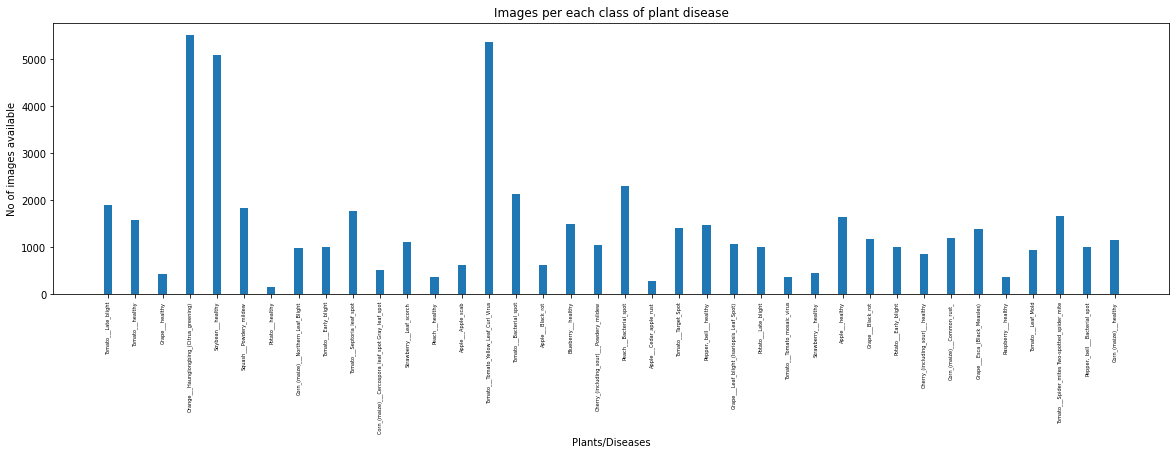

In [7]:
# plotting number of images available for each disease
index = [n for n in range(len(disease_class_size.values()))]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [8]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.27129, 0.28836, 0.26273], std=[0.09086, 0.12649, 0.08288]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [9]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [10]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 16


In [11]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

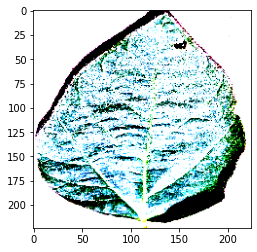

In [12]:
show_image(*train_dataset[21])

In [13]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [14]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

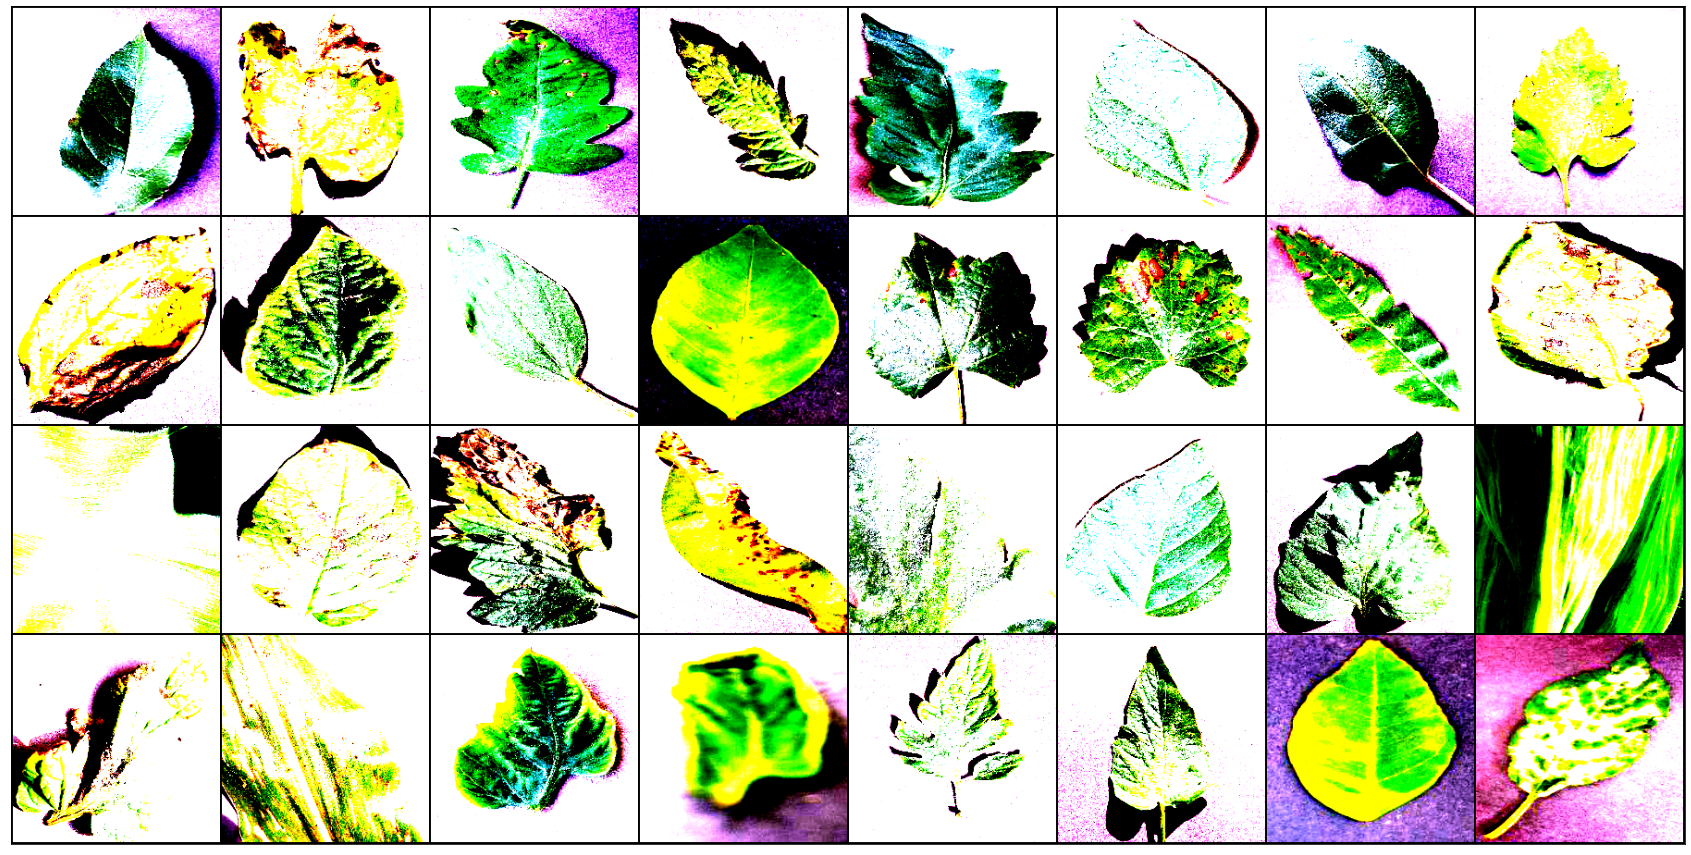

In [15]:
show_batch(train_dataloader)

In [16]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [17]:
# defining the model

model_resnet50 = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
for param in model_resnet50.parameters():
    param.requires_grad = False

num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, out_features=len(train_dataset.dataset.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.fc.parameters(), lr=0.001)

Device: cuda:0


In [19]:
accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []


num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        model_resnet50.train()
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_resnet50.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_resnet50(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = criterion(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/40], Step [100/1188], Loss: 0.9563, Accuracy: 81.25%
Epoch [1/40], Loss: 0.7462, Validation Accuracy: 80.39%
Epoch [1/40], Step [200/1188], Loss: 0.9530, Accuracy: 75.00%
Epoch [1/40], Loss: 0.4375, Validation Accuracy: 88.07%
Epoch [1/40], Step [300/1188], Loss: 0.4701, Accuracy: 90.62%
Epoch [1/40], Loss: 0.3252, Validation Accuracy: 88.99%
Epoch [1/40], Step [400/1188], Loss: 0.5579, Accuracy: 84.38%
Epoch [1/40], Loss: 0.2050, Validation Accuracy: 90.63%
Epoch [1/40], Step [500/1188], Loss: 0.2150, Accuracy: 93.75%
Epoch [1/40], Loss: 0.2329, Validation Accuracy: 92.30%
Epoch [1/40], Step [600/1188], Loss: 0.2799, Accuracy: 90.62%
Epoch [1/40], Loss: 0.1962, Validation Accuracy: 92.45%
Epoch [1/40], Step [700/1188], Loss: 0.4377, Accuracy: 87.50%
Epoch [1/40], Loss: 0.0933, Validation Accuracy: 92.71%
Epoch [1/40], Step [800/1188], Loss: 0.1434, Accuracy: 96.88%
Epoch [1/40], Loss: 0.1262, Validation Accuracy: 94.09%
Epoch [1/40], Step [900/1188], Loss: 0.2916, Accuracy: 8

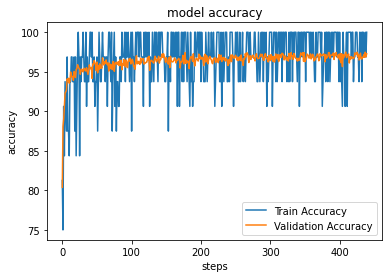

In [20]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_Plantvillage-ResNet50')
plt.show()

In [21]:
str(accuracy_train)

'[81.25, 75.0, 90.625, 84.375, 93.75, 90.625, 87.5, 96.875, 87.5, 87.5, 84.375, 93.75, 93.75, 96.875, 96.875, 93.75, 93.75, 96.875, 87.5, 96.875, 84.375, 90.625, 96.875, 100.0, 96.875, 84.375, 96.875, 93.75, 96.875, 96.875, 100.0, 96.875, 93.75, 93.75, 100.0, 90.625, 96.875, 93.75, 93.75, 96.875, 100.0, 100.0, 96.875, 100.0, 93.75, 93.75, 96.875, 90.625, 93.75, 93.75, 96.875, 87.5, 93.75, 100.0, 96.875, 93.75, 93.75, 96.875, 100.0, 96.875, 96.875, 96.875, 93.75, 96.875, 96.875, 90.625, 96.875, 100.0, 100.0, 96.875, 93.75, 100.0, 87.5, 93.75, 96.875, 100.0, 90.625, 96.875, 87.5, 93.75, 93.75, 90.625, 90.625, 96.875, 96.875, 93.75, 100.0, 96.875, 96.875, 96.875, 100.0, 93.75, 100.0, 96.875, 96.875, 100.0, 96.875, 93.75, 96.875, 100.0, 87.5, 100.0, 96.875, 96.875, 93.75, 96.875, 100.0, 96.875, 100.0, 100.0, 100.0, 96.875, 100.0, 100.0, 96.875, 96.875, 96.875, 90.625, 100.0, 96.875, 100.0, 96.875, 100.0, 96.875, 96.875, 100.0, 90.625, 96.875, 93.75, 93.75, 100.0, 96.875, 93.75, 100.0, 100.

In [22]:
str(accuracy_validation)

'[80.38674033149171, 88.06629834254144, 88.98710865561694, 90.62615101289134, 92.30202578268877, 92.44935543278085, 92.707182320442, 94.08839779005524, 93.86740331491713, 94.1804788213628, 93.55432780847146, 93.79373848987107, 94.97237569060773, 94.67771639042357, 94.30939226519337, 94.32780847145487, 93.92265193370166, 95.02762430939227, 94.76979742173113, 94.27255985267034, 95.30386740331491, 95.34069981583794, 95.89318600368324, 95.69060773480663, 95.451197053407, 95.34069981583794, 94.67771639042357, 95.15653775322284, 95.34069981583794, 95.11970534069981, 94.99079189686924, 95.37753222836096, 95.4327808471455, 95.13812154696133, 95.1012891344383, 95.50644567219153, 95.04604051565377, 94.65930018416206, 95.19337016574586, 95.87476979742173, 95.4327808471455, 95.37753222836096, 95.56169429097606, 94.16206261510129, 95.9852670349908, 95.89318600368324, 96.40883977900553, 96.15101289134438, 95.94843462246777, 95.13812154696133, 96.22467771639043, 94.86187845303867, 95.78268876611418, 

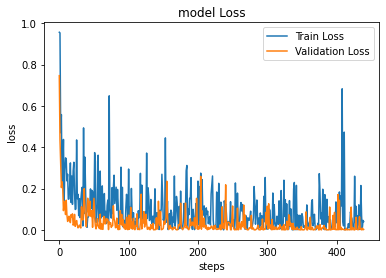

In [23]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Loss_Plot_Plantvillage-ResNet50')
plt.show()

In [24]:
str(loss_train)

'[0.9563459753990173, 0.9530470967292786, 0.47005540132522583, 0.557918906211853, 0.21496771275997162, 0.279921293258667, 0.4377357065677643, 0.1434360295534134, 0.29164057970046997, 0.34875941276550293, 0.3432996869087219, 0.23708632588386536, 0.2694721817970276, 0.1485430747270584, 0.15014271438121796, 0.2152891308069229, 0.3240964710712433, 0.13299737870693207, 0.26065489649772644, 0.1235586628317833, 0.2849893867969513, 0.3273870348930359, 0.17491070926189423, 0.09889300912618637, 0.10175236314535141, 0.43529343605041504, 0.1511087715625763, 0.1723387986421585, 0.06908632069826126, 0.15143422782421112, 0.059372853487730026, 0.14362026751041412, 0.1808689534664154, 0.20599967241287231, 0.01914076879620552, 0.49352511763572693, 0.07947029918432236, 0.3522335886955261, 0.1753562092781067, 0.06898238509893417, 0.012579670175909996, 0.06055736914277077, 0.06274314224720001, 0.11123470216989517, 0.12169349938631058, 0.1983419507741928, 0.10437646508216858, 0.19131071865558624, 0.09820684

In [25]:
str(loss_validation)

'[0.7462382912635803, 0.43752604722976685, 0.32521122694015503, 0.20498062670230865, 0.2329169362783432, 0.19621166586875916, 0.09329013526439667, 0.12619119882583618, 0.13743935525417328, 0.07431955635547638, 0.14376825094223022, 0.07281655073165894, 0.04103177785873413, 0.048819731920957565, 0.06646560877561569, 0.048236943781375885, 0.03524601832032204, 0.07406730204820633, 0.0637693926692009, 0.0777721107006073, 0.023012099787592888, 0.030222218483686447, 0.07515773922204971, 0.017127547413110733, 0.0344264842569828, 0.04544992744922638, 0.022298045456409454, 0.010003279894590378, 0.013912763446569443, 0.02357281930744648, 0.015470534563064575, 0.009376532398164272, 0.11212792247533798, 0.05659361183643341, 0.04773679003119469, 0.11646977066993713, 0.1997528076171875, 0.08884488791227341, 0.0593840628862381, 0.015071860514581203, 0.09355796128511429, 0.15338276326656342, 0.09044007211923599, 0.06735365837812424, 0.13990569114685059, 0.07641548663377762, 0.06461989134550095, 0.09364

In [26]:
torch.save(model_resnet50, '/kaggle/working/Model_Plantvillage-ResNet50.pth')
# model = torch.load('model.pth')

In [27]:
print(accuracy_train)

[81.25, 75.0, 90.625, 84.375, 93.75, 90.625, 87.5, 96.875, 87.5, 87.5, 84.375, 93.75, 93.75, 96.875, 96.875, 93.75, 93.75, 96.875, 87.5, 96.875, 84.375, 90.625, 96.875, 100.0, 96.875, 84.375, 96.875, 93.75, 96.875, 96.875, 100.0, 96.875, 93.75, 93.75, 100.0, 90.625, 96.875, 93.75, 93.75, 96.875, 100.0, 100.0, 96.875, 100.0, 93.75, 93.75, 96.875, 90.625, 93.75, 93.75, 96.875, 87.5, 93.75, 100.0, 96.875, 93.75, 93.75, 96.875, 100.0, 96.875, 96.875, 96.875, 93.75, 96.875, 96.875, 90.625, 96.875, 100.0, 100.0, 96.875, 93.75, 100.0, 87.5, 93.75, 96.875, 100.0, 90.625, 96.875, 87.5, 93.75, 93.75, 90.625, 90.625, 96.875, 96.875, 93.75, 100.0, 96.875, 96.875, 96.875, 100.0, 93.75, 100.0, 96.875, 96.875, 100.0, 96.875, 93.75, 96.875, 100.0, 87.5, 100.0, 96.875, 96.875, 93.75, 96.875, 100.0, 96.875, 100.0, 100.0, 100.0, 96.875, 100.0, 100.0, 96.875, 96.875, 96.875, 90.625, 100.0, 96.875, 100.0, 96.875, 100.0, 96.875, 96.875, 100.0, 90.625, 96.875, 93.75, 93.75, 100.0, 96.875, 93.75, 100.0, 100.0

In [28]:
print(accuracy_validation)

[80.38674033149171, 88.06629834254144, 88.98710865561694, 90.62615101289134, 92.30202578268877, 92.44935543278085, 92.707182320442, 94.08839779005524, 93.86740331491713, 94.1804788213628, 93.55432780847146, 93.79373848987107, 94.97237569060773, 94.67771639042357, 94.30939226519337, 94.32780847145487, 93.92265193370166, 95.02762430939227, 94.76979742173113, 94.27255985267034, 95.30386740331491, 95.34069981583794, 95.89318600368324, 95.69060773480663, 95.451197053407, 95.34069981583794, 94.67771639042357, 95.15653775322284, 95.34069981583794, 95.11970534069981, 94.99079189686924, 95.37753222836096, 95.4327808471455, 95.13812154696133, 95.1012891344383, 95.50644567219153, 95.04604051565377, 94.65930018416206, 95.19337016574586, 95.87476979742173, 95.4327808471455, 95.37753222836096, 95.56169429097606, 94.16206261510129, 95.9852670349908, 95.89318600368324, 96.40883977900553, 96.15101289134438, 95.94843462246777, 95.13812154696133, 96.22467771639043, 94.86187845303867, 95.78268876611418, 9

In [29]:
print(loss_train)

[0.9563459753990173, 0.9530470967292786, 0.47005540132522583, 0.557918906211853, 0.21496771275997162, 0.279921293258667, 0.4377357065677643, 0.1434360295534134, 0.29164057970046997, 0.34875941276550293, 0.3432996869087219, 0.23708632588386536, 0.2694721817970276, 0.1485430747270584, 0.15014271438121796, 0.2152891308069229, 0.3240964710712433, 0.13299737870693207, 0.26065489649772644, 0.1235586628317833, 0.2849893867969513, 0.3273870348930359, 0.17491070926189423, 0.09889300912618637, 0.10175236314535141, 0.43529343605041504, 0.1511087715625763, 0.1723387986421585, 0.06908632069826126, 0.15143422782421112, 0.059372853487730026, 0.14362026751041412, 0.1808689534664154, 0.20599967241287231, 0.01914076879620552, 0.49352511763572693, 0.07947029918432236, 0.3522335886955261, 0.1753562092781067, 0.06898238509893417, 0.012579670175909996, 0.06055736914277077, 0.06274314224720001, 0.11123470216989517, 0.12169349938631058, 0.1983419507741928, 0.10437646508216858, 0.19131071865558624, 0.098206847

In [30]:
print(loss_validation)

[0.7462382912635803, 0.43752604722976685, 0.32521122694015503, 0.20498062670230865, 0.2329169362783432, 0.19621166586875916, 0.09329013526439667, 0.12619119882583618, 0.13743935525417328, 0.07431955635547638, 0.14376825094223022, 0.07281655073165894, 0.04103177785873413, 0.048819731920957565, 0.06646560877561569, 0.048236943781375885, 0.03524601832032204, 0.07406730204820633, 0.0637693926692009, 0.0777721107006073, 0.023012099787592888, 0.030222218483686447, 0.07515773922204971, 0.017127547413110733, 0.0344264842569828, 0.04544992744922638, 0.022298045456409454, 0.010003279894590378, 0.013912763446569443, 0.02357281930744648, 0.015470534563064575, 0.009376532398164272, 0.11212792247533798, 0.05659361183643341, 0.04773679003119469, 0.11646977066993713, 0.1997528076171875, 0.08884488791227341, 0.0593840628862381, 0.015071860514581203, 0.09355796128511429, 0.15338276326656342, 0.09044007211923599, 0.06735365837812424, 0.13990569114685059, 0.07641548663377762, 0.06461989134550095, 0.093642

In [31]:
model_resnet50.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_resnet50(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 97.26%


In [32]:
y_pred = []
y_true = []
features_tsne = None

model_resnet50.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_resnet50(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 97.35%


In [33]:
str(y_pred)

'[4, 8, 15, 9, 3, 26, 34, 18, 10, 19, 30, 30, 12, 13, 11, 25, 15, 10, 36, 13, 7, 15, 15, 0, 35, 18, 24, 33, 24, 34, 1, 16, 24, 15, 7, 27, 0, 5, 19, 33, 1, 24, 24, 19, 19, 21, 8, 15, 5, 11, 12, 30, 5, 35, 15, 31, 24, 0, 9, 31, 1, 35, 35, 16, 3, 16, 3, 12, 7, 9, 12, 8, 15, 26, 37, 34, 14, 13, 18, 8, 32, 25, 24, 16, 19, 26, 11, 5, 10, 15, 28, 32, 15, 34, 24, 15, 26, 15, 24, 12, 16, 18, 35, 24, 28, 19, 12, 3, 5, 4, 6, 8, 16, 11, 5, 15, 24, 30, 15, 35, 25, 24, 15, 19, 28, 0, 21, 15, 15, 30, 24, 35, 28, 19, 34, 33, 33, 4, 15, 24, 9, 32, 33, 15, 21, 14, 1, 11, 35, 28, 8, 35, 35, 15, 18, 5, 37, 10, 7, 6, 35, 32, 30, 14, 23, 20, 35, 35, 35, 26, 24, 13, 28, 25, 15, 15, 5, 31, 35, 1, 15, 1, 4, 3, 22, 24, 13, 10, 35, 34, 18, 14, 22, 30, 11, 34, 3, 26, 35, 19, 24, 4, 30, 26, 24, 37, 13, 31, 34, 37, 6, 25, 32, 11, 26, 4, 25, 32, 35, 3, 24, 16, 32, 36, 25, 16, 13, 32, 32, 20, 15, 15, 15, 24, 15, 35, 35, 35, 30, 6, 25, 5, 27, 24, 33, 8, 29, 5, 2, 35, 35, 26, 24, 35, 13, 20, 24, 16, 16, 15, 24, 13, 24,

In [34]:
str(y_true)

'[4, 8, 15, 9, 3, 26, 34, 18, 10, 19, 30, 30, 12, 13, 11, 25, 15, 10, 36, 13, 7, 15, 15, 0, 35, 18, 24, 33, 24, 34, 1, 16, 24, 15, 7, 27, 0, 5, 19, 33, 0, 24, 24, 19, 19, 21, 8, 15, 5, 11, 11, 30, 5, 35, 15, 31, 24, 0, 9, 31, 1, 35, 35, 16, 3, 16, 3, 12, 7, 9, 12, 8, 15, 26, 37, 34, 14, 13, 18, 8, 32, 25, 24, 16, 19, 26, 11, 5, 10, 15, 28, 32, 15, 29, 24, 15, 26, 15, 24, 12, 16, 18, 35, 24, 28, 19, 12, 3, 5, 4, 6, 8, 16, 11, 5, 15, 24, 30, 15, 35, 25, 24, 15, 19, 28, 0, 22, 15, 15, 30, 24, 35, 28, 19, 34, 33, 33, 4, 15, 24, 8, 32, 33, 15, 21, 14, 1, 11, 35, 28, 8, 35, 35, 15, 18, 5, 37, 10, 7, 6, 35, 34, 30, 14, 23, 20, 35, 35, 35, 26, 19, 13, 28, 25, 15, 15, 5, 33, 35, 1, 15, 1, 4, 3, 22, 24, 13, 10, 35, 33, 18, 14, 22, 30, 11, 34, 3, 26, 35, 19, 24, 4, 30, 26, 24, 37, 13, 31, 34, 37, 6, 25, 32, 11, 26, 4, 25, 32, 35, 3, 24, 16, 32, 36, 25, 16, 13, 32, 32, 20, 15, 15, 15, 24, 15, 35, 31, 35, 30, 6, 25, 5, 27, 24, 33, 8, 29, 5, 2, 35, 33, 26, 24, 35, 13, 20, 24, 16, 16, 15, 24, 13, 24,

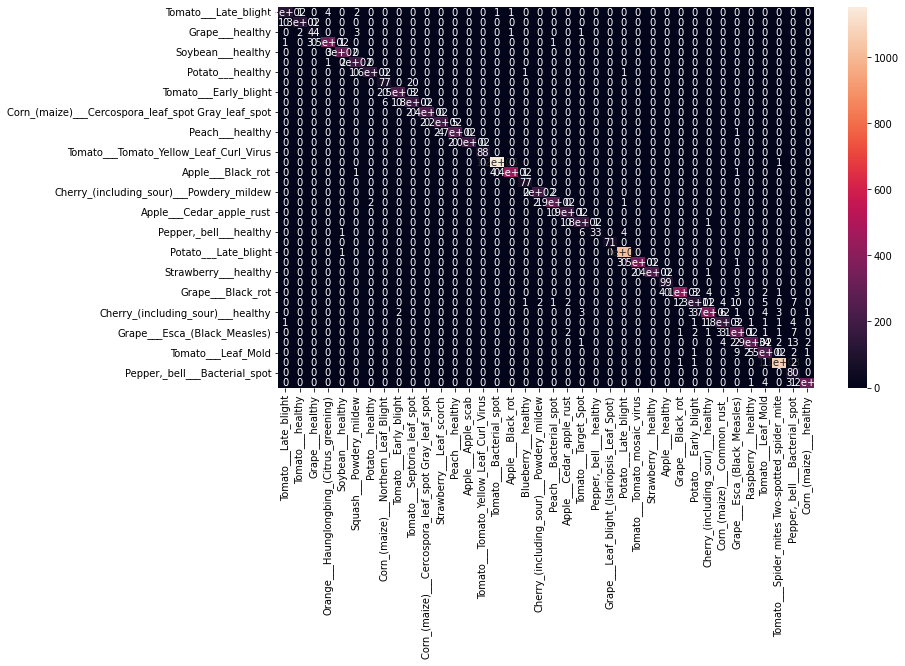

In [35]:
confusion_matrix_vec = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix_vec,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_Plantvillage-ResNet50.png')

In [36]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 97.35%
Precision: 97.49%
Sensitivity_recall: 97.35%
Specificity: 97.35%
F1 Score: 97.34%


In [37]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_Plantvillage-ResNet50')
    plt.show()

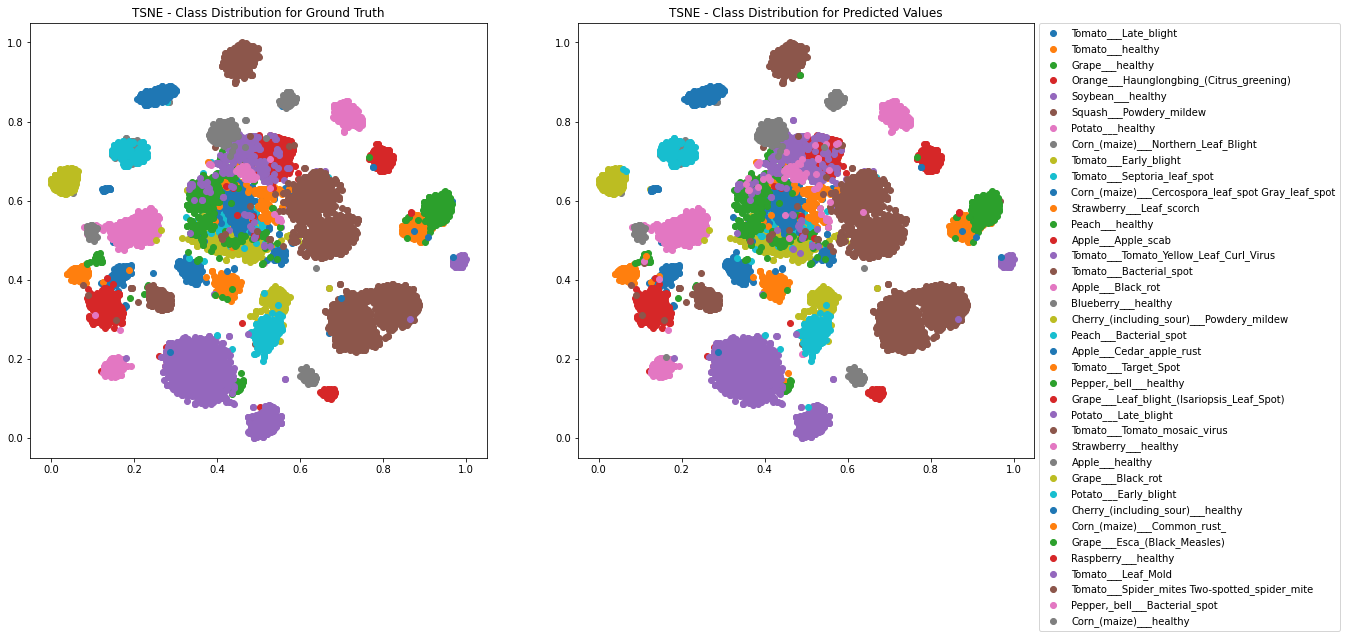

In [38]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')

In [39]:
for i, data in enumerate(train_dataloader):
    len(data)

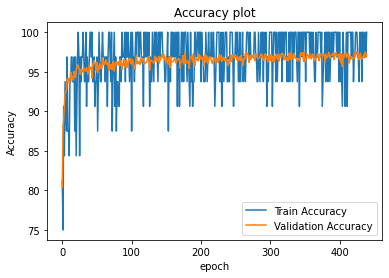

In [40]:
####### plot the the training accuracies here #########
num_epochs = 20

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend()
plt.show()

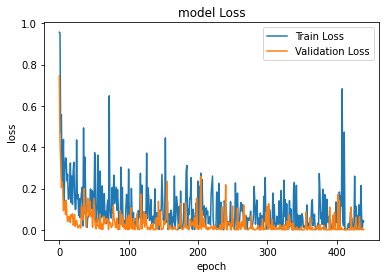

In [41]:
####### plot the the training accuracies here #########
num_epochs = 20

epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model Loss')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend()
plt.show()

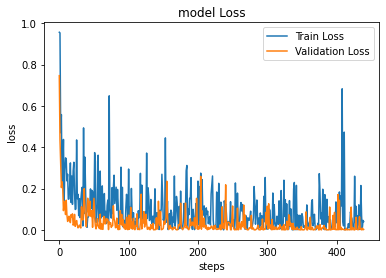

In [42]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()